In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
import torch.nn.functional as F


import os
import time
import tqdm
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from timeit import default_timer as timer

import importlib
import utils

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# The Black Scholes Formula
The Black–Scholes formula calculates the price of European put and call options. This price is consistent with the Black–Scholes equation. This follows since the formula can be obtained by solving the equation for the corresponding terminal and boundary conditions:
$$    

    {\begin{aligned}&C(0,t)=0{\text{ for all }}t\\&C(S,t)\rightarrow S-K{\text{ as }}S\rightarrow \infty \\&C(S,T)=\max\{S-K,0\}\end{aligned}}

    $$

The value of a call option for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

$$
    {\begin{aligned}C(S_{t},t)&=N(d_{+})S_{t}-N(d_{-})Ke^{-r(T-t)}\\d_{+}&={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\d_{-}&=d_{+}-\sigma {\sqrt {T-t}}\\\end{aligned}}
    $$

The price of a corresponding put option based on put–call parity with discount factor $e^{{-r(T-t)}}$ is:
$$
    {\begin{aligned}P(S_{t},t)&=Ke^{-r(T-t)}-S_{t}+C(S_{t},t)\\&=N(-d_{-})Ke^{-r(T-t)}-N(-d_{+})S_{t}\end{aligned}}\,
    $$

In [5]:
S = torch.Tensor([80]).requires_grad_()
t = torch.Tensor([0]).requires_grad_()
sigma = torch.Tensor([0.3]).requires_grad_()
r = torch.Tensor([0.05]).requires_grad_()
K = torch.Tensor([70])
T = torch.Tensor([1])
t2m = T-t
d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m)/(sigma * torch.sqrt(t2m))
d2 = d1 - sigma * torch.sqrt(t2m)
N0 = lambda value: 0.5 * (1 + torch.erf((value/2**0.5)))
Nd1 = N0(d1)
Nd2 = N0(d2)
C = S* Nd1 - K* Nd2 *torch.exp(-r*t2m)
print("Option Price:", C.item()) #17.01496

Option Price: 17.01496124267578


# The Black Scholes Equation
The gradient is calculated using the auto gradient method in pytorch.

$$
{\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0
$$

To check the correctness of the calculation, it uses the Greeks equation from the Black-Scholes Formula.

In [6]:
dCdt, = tgrad.grad(C, t, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
dCdS, = tgrad.grad(C, S, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
d2CdS2, = tgrad.grad(dCdS, S, grad_outputs=torch.ones(dCdS.shape), create_graph=True, only_inputs=True)
dCdvol, = tgrad.grad(C, sigma, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)

dCdr, = tgrad.grad(C, r, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
theta, delta, gamma, vega, rho = -dCdt[0], dCdS[0], d2CdS2[0], dCdvol[0], dCdr[0]

print(f'{theta.item():.4f}', f'{delta.item():.4f}', f'{gamma.item():.4f}', f'{vega.item():.4f}', f'{rho.item():.4f}')
# Theta 5.8385 Delta 0.7769 Gamma 0.0124 Vega 23.8776 Rho 45.1372

5.8385 0.7769 0.0124 23.8776 45.1372


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [7]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

In [8]:
samples = {"pde": 5000, "bc":500, "fc":500}

bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)

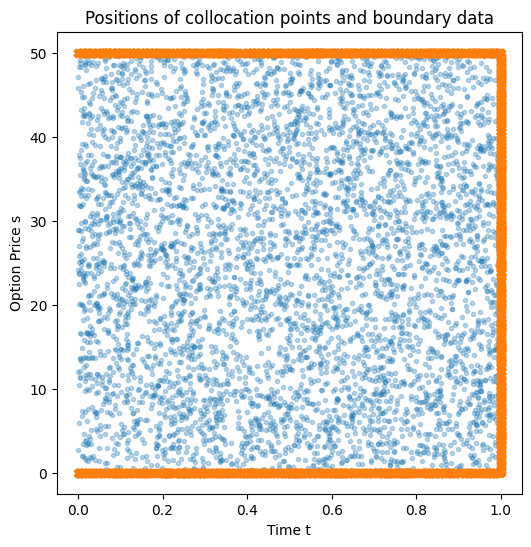

In [9]:
fig = plt.figure(figsize=(6,6))
plt.scatter([sublist[0] for sublist in n_st_train], [sublist[1] for sublist in n_st_train], marker='.',alpha=0.3)
plt.scatter([sublist[0] for sublist in bc_st_train], [sublist[1] for sublist in bc_st_train], marker='X')
plt.xlabel('Time t')
plt.ylabel('Option Price s')

plt.title('Positions of collocation points and boundary data');

In [10]:
# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Hyperparameters


In [11]:
n_epochs = 20000
lossFunction = nn.MSELoss()
sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 1]
lr = 3e-5
activation = 'relu'
optimizer = 'adam'
loss_weights = [1, 1, 1]

# PINN vs IPINN vs AWPINN

In [10]:
pinn, loss_list, min_model = utils.network_training(
    K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
    device=device, net='pinn', opt=optimizer, sizes=sizes, activation=activation, learning_rate=lr, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=None, adaptive_rate_scaler=0, loss_weights=loss_weights, adaptive_weight=None, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
    )

torch.save(min_model, "pinn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_list)
loss_df.to_csv('pinn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [09:12<00:00, 36.20it/s]


In [11]:
ipinn, loss_list2, min_model = utils.network_training(
    K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
    device=device, net='ipinn', opt=optimizer, sizes=sizes, activation=activation, learning_rate=lr, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate =0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=loss_weights, adaptive_weight=None, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
    )

torch.save(min_model, "ipinn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_list2)
loss_df.to_csv('ipinn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [10:58<00:00, 30.36it/s]


In [12]:
awpinn, loss_list4, min_model = utils.network_training(
    K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
    device=device, net='pinn', opt=optimizer, sizes=sizes, activation=activation, learning_rate=lr, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=None, adaptive_rate_scaler=0, loss_weights=loss_weights, adaptive_weight=True, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
    )

torch.save(min_model, "awpinn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_list4)
loss_df.to_csv('awpinn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [07:33<00:00, 44.08it/s]


In [13]:
awipinn, loss_list5, min_model = utils.network_training(
    K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
    device=device, net='ipinn', opt=optimizer, sizes=sizes, activation=activation, learning_rate=lr, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=loss_weights, adaptive_weight=True, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
    )

torch.save(min_model, "awipinn.pth")  # Save the model's state dictionary
# Save the training loss history as a CSV file
loss_df = pd.DataFrame(loss_list5)
loss_df.to_csv('awipinn_loss.csv', index=False)

[Training procedure]: 100%|##########| 20000/20000 [09:41<00:00, 34.42it/s]


In [ ]:
# extract data
loss_list = pd.read_csv('pinn_loss.csv').to_numpy()
loss_list2 = pd.read_csv('ipinn_loss.csv').to_numpy()
loss_list4 = pd.read_csv('awpinn_loss.csv').to_numpy()
print('Done')

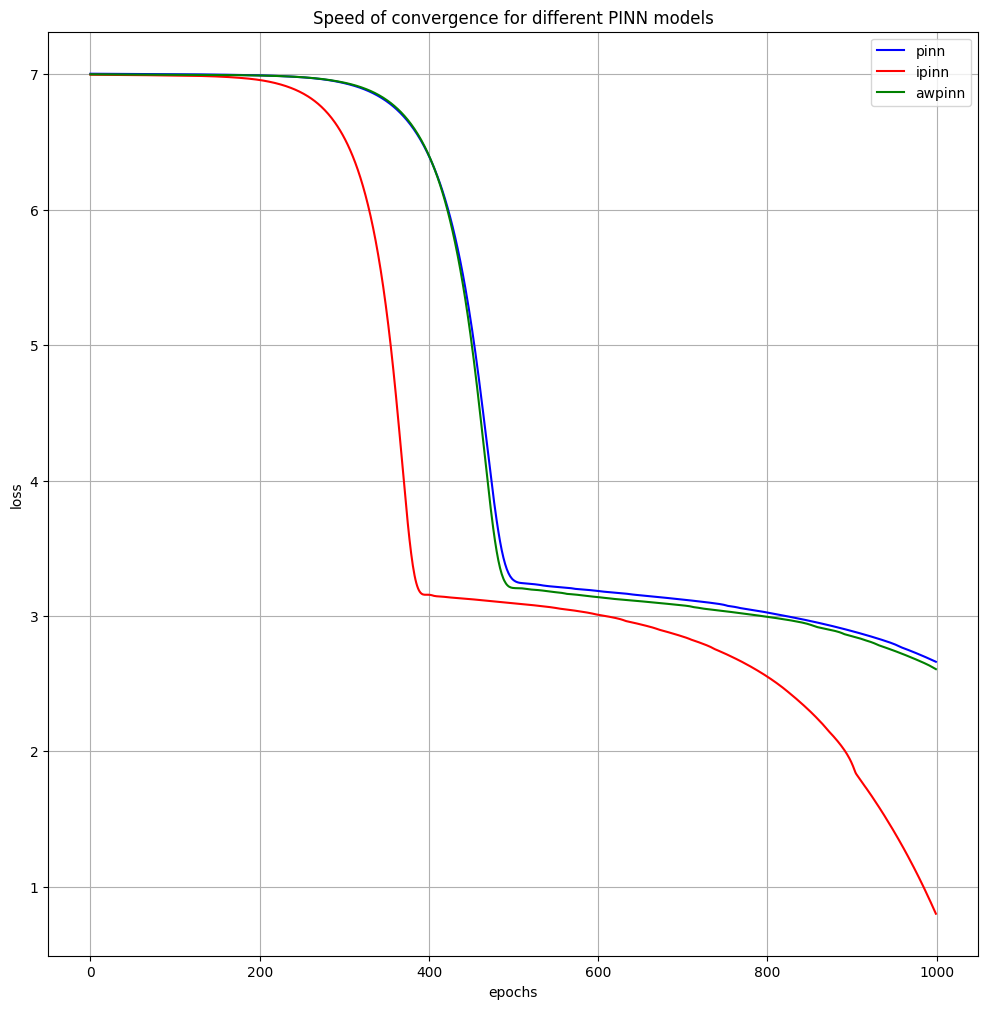

In [19]:
fig = plt.figure(figsize=(12,12))
plt.plot(range(1000), [np.log(item) for item in loss_list[:1000]], color='blue', label='pinn')
plt.plot(range(1000), [np.log(item) for item in loss_list2[:1000]], color='red', label='ipinn')
# plt.plot(range(2000), [np.log(item) for item in loss_list3[:4000]], color='green', label='ipinn2')
plt.plot(range(1000), [np.log(item) for item in loss_list4[:1000]], color='green', label='awpinn')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'Speed of convergence for different PINN models')
plt.grid(True)

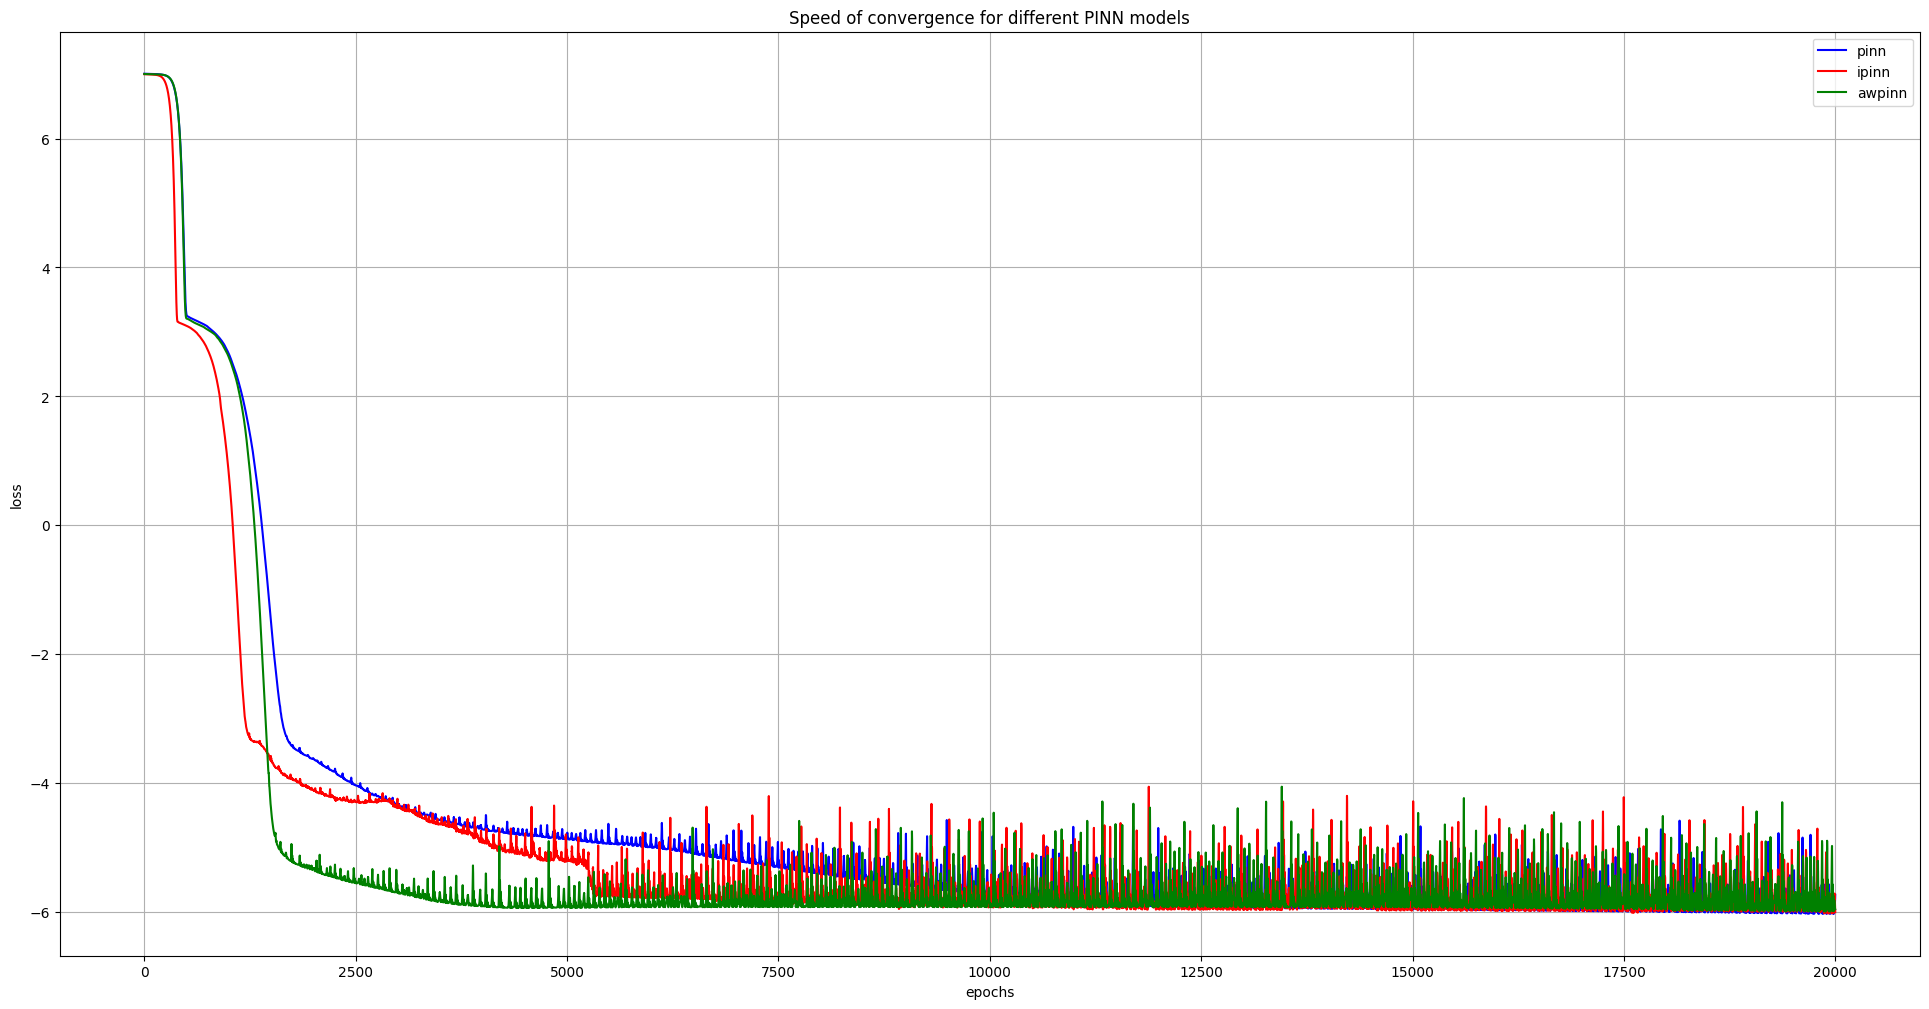

In [20]:
fig = plt.figure(figsize=(24,12))
plt.plot(range(20000), [np.log(item) for item in loss_list[:20000]], color='blue', label='pinn')
plt.plot(range(20000), [np.log(item) for item in loss_list2[:20000]], color='red', label='ipinn')
# plt.plot(range(30000), [np.log(item) for item in loss_list3[:30000]], color='green', label='ipinn2')
plt.plot(range(20000), [np.log(item) for item in loss_list4[:20000]], color='green', label='awpinn')
# plt.plot(range(30000), [np.log(item) for item in loss_list4[:30000]], color='yellow', label='wpinn')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'Speed of convergence for different PINN models')
plt.grid(True)

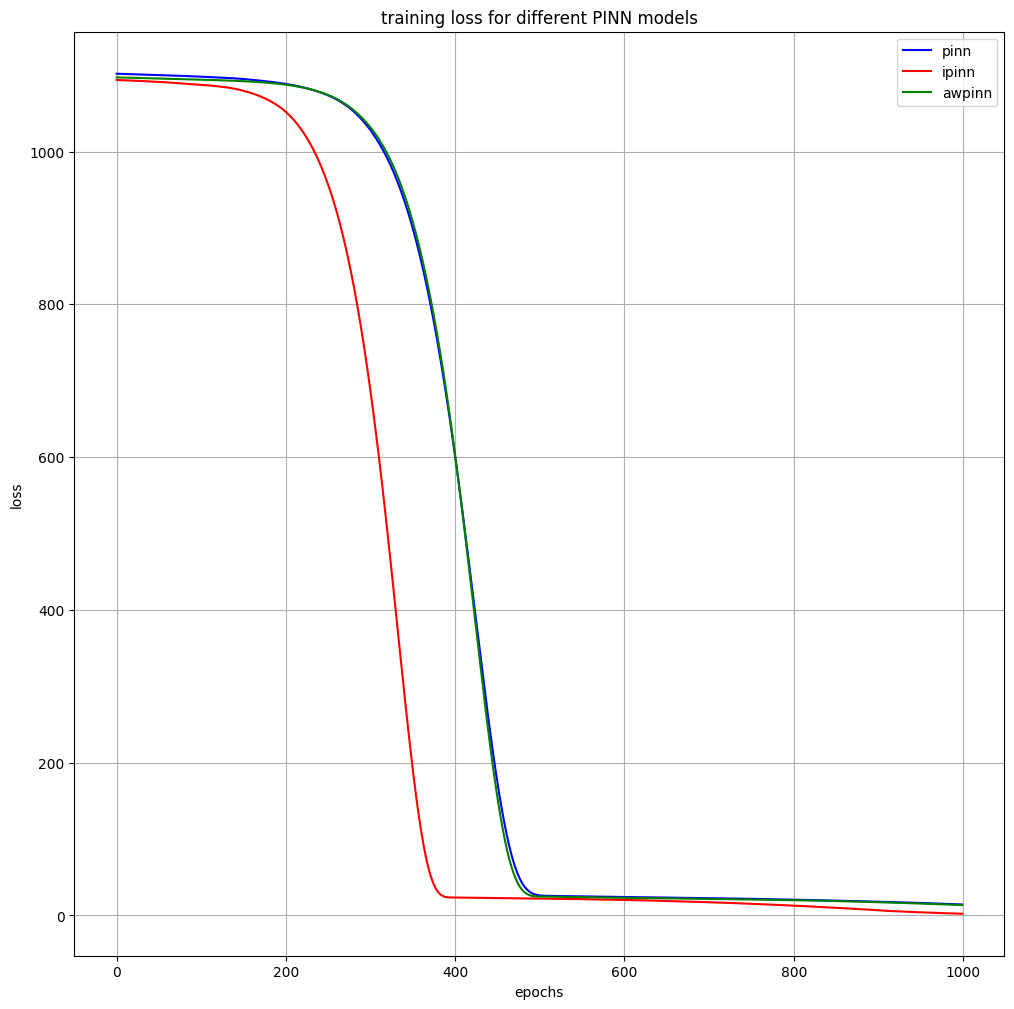

In [21]:
fig = plt.figure(figsize=(12,12))
plt.plot(range(1000), loss_list[:1000], color='blue', label='pinn')
plt.plot(range(1000), loss_list2[:1000], color='red', label='ipinn')
plt.plot(range(1000), loss_list4[:1000], color='green', label='awpinn')
# plt.plot(range(6000), loss_list5[:6000], color='green', label='wipinn')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'training loss for different PINN models')
plt.grid(True)

## PINN with Different Loss weights

In [ ]:
weights = [[0.5, 0.25, 0.25], [0.25, 0.5, 0.25], [0.25, 0.25, 0.5], [0.7, 0.15, 0.15], [0.15, 0.7, 0.15], [0.15, 0.15, 0.7]]

In [ ]:
models = []
loss_hists_lists = []
n_epochs = 5000

# train models with different weights
for i in range(len(weights)):
    w1 = weights[i][0]
    w2 = weights[i][1]
    w3 = weights[i][2]
    wpinn, loss_list, min_model = utils.network_training(
        K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
        device=device, net='pinn', opt='adam', sizes=sizes, activation='relu', learning_rate=lr, n_epochs=n_epochs, 
        lossFunction=lossFunction, dropout_rate=None, adaptive_rate=None, adaptive_rate_scaler=None, loss_weights=weights[i], adaptive_weight=None, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
        )
    torch.save(wpinn.state_dict(), f"pinn-weight-test/pinn-{w1}-{w2}-{w3}.pth")  # Save the model's state dictionary
    # Save the training loss history as a CSV file
    loss_df = pd.DataFrame({'Loss': loss_list})
    loss_df.to_csv(f'pinn-weight-test/pinn-{w1}-{w2}-{w3}_loss.csv', index=False)
    pass

In [ ]:
# extract data
for i in range(len(weights)):
    loss_hists_lists.append(pd.read_csv(f'pinn-weight-test/pinn-{weights[i][0]}-{weights[i][1]}_loss.csv'))
    pass
print('Done')

Done


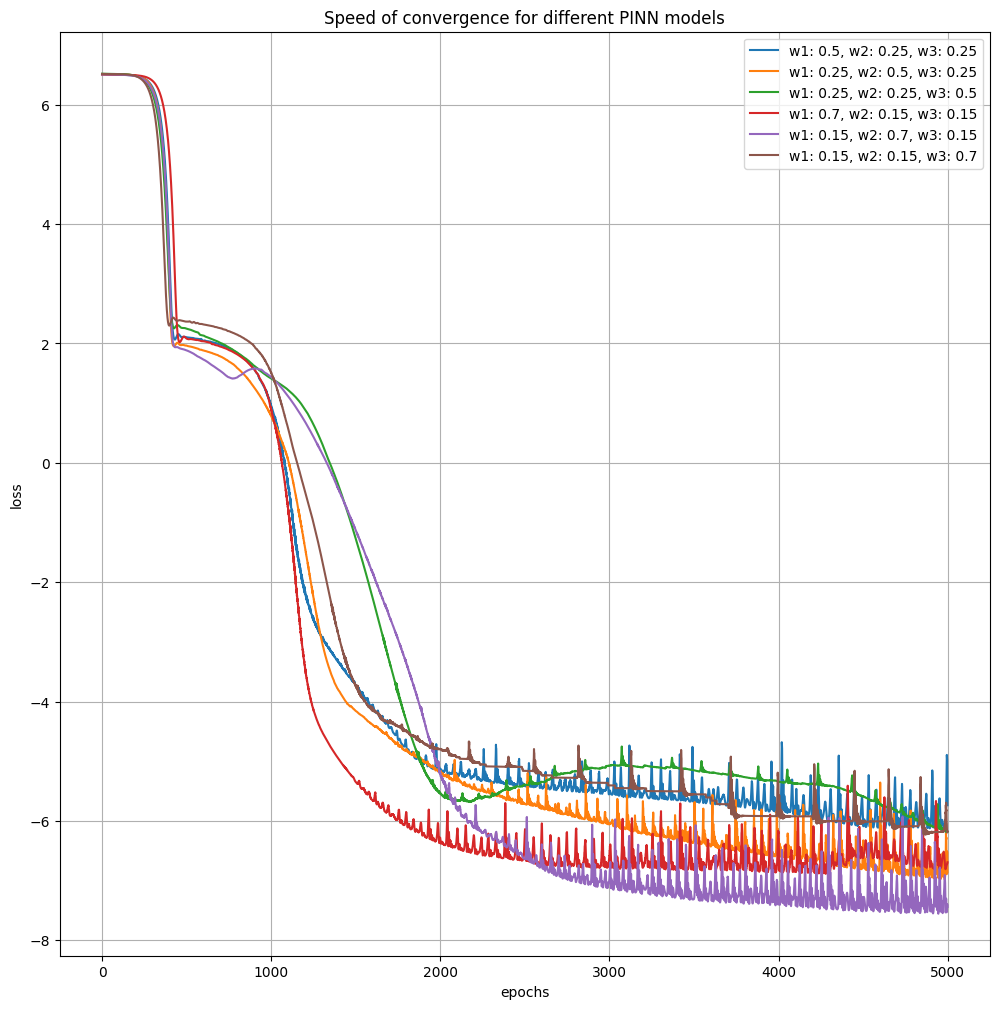

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in range(len(weights)):
    plt.plot(range(n_epochs), [np.log(item) for item in loss_hists_lists[i]['Loss']], label=f'w1: {weights[i][0]}, w2: {weights[i][1]}, w3: {weights[i][2]}')
    pass
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'Speed of convergence for different PINN models')
plt.grid(True)

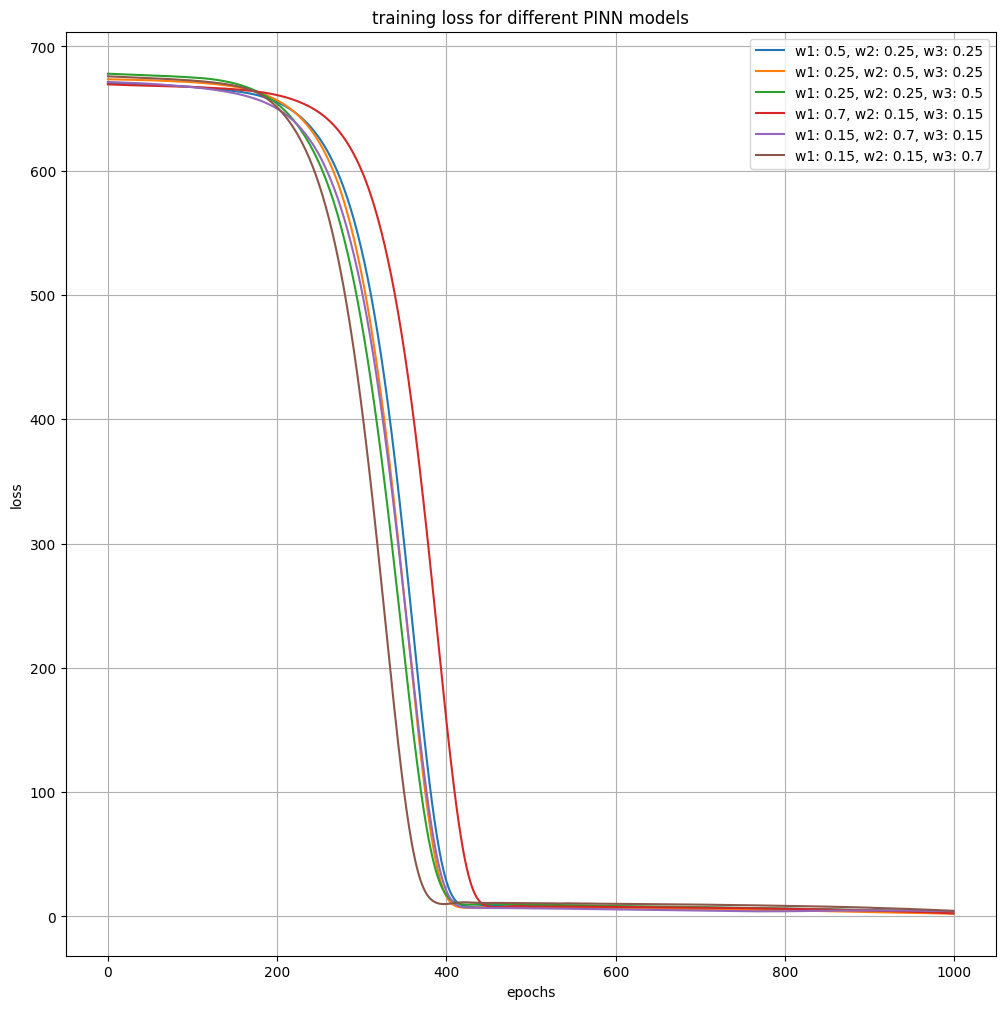

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in range(len(weights)):
    plt.plot(range(1000), [item for item in loss_hists_lists[i]['Loss'][:1000]], label=f'w1: {weights[i][0]}, w2: {weights[i][1]}, w3: {weights[i][2]}')
    pass
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'training loss for different PINN models')
plt.grid(True)

# IPINN with Different loss weights

In [ ]:
models = []
loss_hists_lists = []

# train models with different weights
for i in range(len(weights)):
    w1 = weights[i][0]
    w2 = weights[i][1]
    w3 = weights[i][2]
    wpinn, loss_list, min_model = utils.network_training(
        K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
        device=device, net='ipinn', opt='adam', sizes=sizes, activation='relu', learning_rate=lr, n_epochs=n_epochs, 
        lossFunction=lossFunction, dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=weights[i], adaptive_weight=None, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
        )
    torch.save(wpinn.state_dict(), f"ipinn-weight-test/ipinn-{w1}-{w2}-{w3}.pth")  # Save the model's state dictionary
    # Save the training loss history as a CSV file
    loss_df = pd.DataFrame({'Loss': loss_list})
    loss_df.to_csv(f'ipinn-weight-test/ipinn-{w1}-{w2}-{w3}_loss.csv', index=False)
    pass

# extract data
for i in range(len(weights)):
    loss_hists_lists.append(pd.read_csv(f'ipinn-weight-test/ipinn-{weights[i][0]}-{weights[i][1]}-{weights[i][2]}_loss.csv'))
    pass
print('Done')

[Training procedure]: 100%|##########| 5000/5000 [02:07<00:00, 39.27it/s]

Done


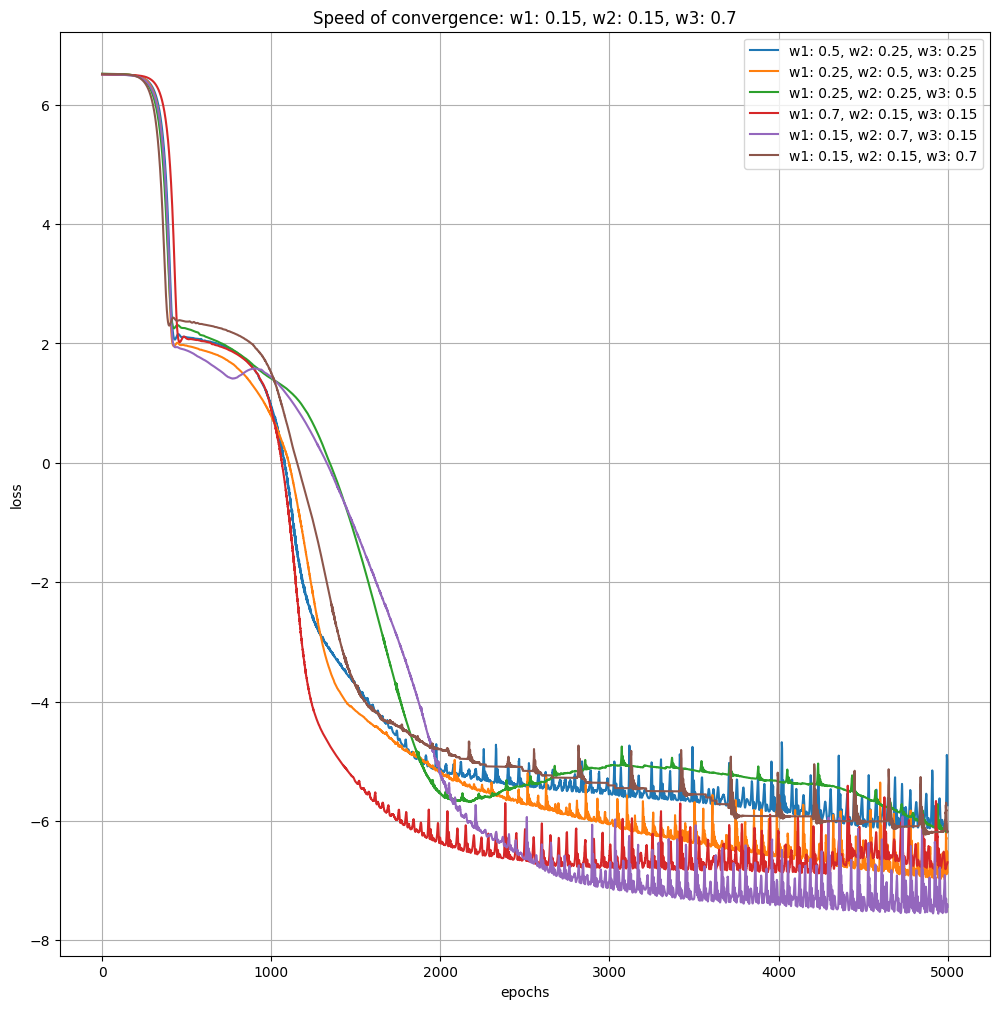

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in range(len(weights)):
    plt.plot(range(n_epochs), [np.log(item) for item in loss_hists_lists[i]['Loss']], label=f'w1: {weights[i][0]}, w2: {weights[i][1]}, w3: {weights[i][2]}')
    pass
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'Speed of convergence: w1: {w1}, w2: {w2}, w3: {w3}')
plt.grid(True)

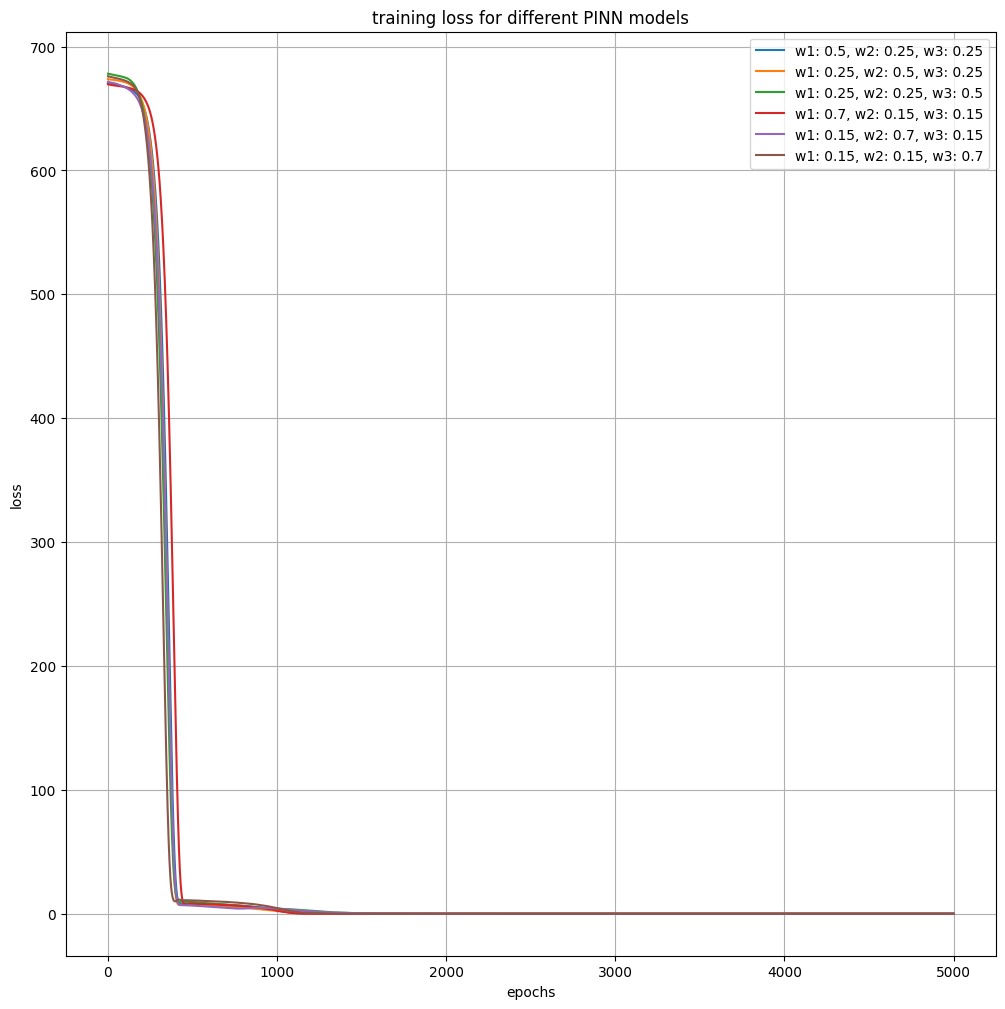

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in range(len(weights)):
    plt.plot(range(5000), [item for item in loss_hists_lists[i]['Loss'][:5000]], label=f'w1: {weights[i][0]}, w2: {weights[i][1]}, w3: {weights[i][2]}')
    pass
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title(f'training loss for different IPINN models')
plt.grid(True)

# Training Plot


In [ ]:
# # Load the entire model
# loaded_model = torch.load('model.pth')

# # Load the model's state dictionary
# model = YourModelClass()  # Instantiate the model with the same architecture
# model.load_state_dict(torch.load('model_state_dict.pth'))

# Test error

In [ ]:
# data = pd.read_csv("sample.csv")
# # Create a mapping from column names to integers
# column_to_int_mapping = {col: idx for idx, col in enumerate(data.columns)}

# ss = 250/200
# st = 1 / 10000


# input_data = []
# output_data = []
# for row_index, row in data.iterrows():
#     for col_index, value in enumerate(row):
#         input_data.append([(10000-row_index)*st, col_index*ss])  # Store row and column index as input
#         output_data.append([value])  # Store the corresponding value as output

In [ ]:
# print(input_data[0])
# print(input_data[199])
# print(input_data[200])
# print(input_data[300])
# print(input_data[100000])
# print(len(input_data))
# # print(data[input_data[0][0]][input_data[0][1]])
# # print(data[input_data[0]])
# print(output_data[0])
# print(output_data[199])

In [ ]:
# # input_data = np.array(input_data)   # If using NumPy
# # output_data = np.array(output_data) # If using NumPy

# X = torch.tensor(input_data, dtype=torch.float32).to(device)
# y = torch.tensor(output_data, dtype=torch.float32).to(device)

# # Assuming you have defined your models 'pinn' and 'ipinn'
# # Compute predictions for both models
# predictions_pinn = pinn(X)
# # print(len(predictions_pinn))
# predictions_ipinn = ipinn(X)
# # predictions_ipinn1 = ipinn1(X)
# predictions_awpinn = awpinn(X)

# print(predictions_pinn[0])
# print(predictions_ipinn[0])
# print(predictions_awpinn[0])
# print(predictions_pinn[1])
# print(predictions_ipinn[1])
# print(predictions_awpinn[1])
# print(y[0])
# print(y[1])

# print(predictions_pinn[199])
# print(predictions_ipinn[199])
# print(predictions_awpinn[199])
# # print(output_data[199])
# print(y[199])

# print(predictions_pinn[200])
# print(predictions_ipinn[200])
# print(predictions_awpinn[200])
# # print(output_data[199])
# print(y[200])


# # torch.cuda.empty_cache()

# # # Calculate losses for both models
# loss1 = lossFunction(predictions_pinn, y)
# loss2 = lossFunction(predictions_ipinn, y)
# loss3 = lossFunction(predictions_awpinn, y)

# print(f'the loss of pinn is {loss1.item()}, the loss of ipinn is {loss2.item()}, the loss of awpinn is {loss3.item()}')